First analysis of the Hainich data using GPFA for filling the gaps

In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
from gpfa_imputation.imputation import *

import pandas as pd
from pathlib import Path
from pyprojroot import here
import matplotlib.pyplot as plt

## Load Data

take the first 200 rows from the Hainich dataset

In [3]:
hai_path = Path("FLX_DE-Hai_FLUXNET2015_FULLSET_HH_2000-2012_1-4.csv")
hai_raw = pd.read_csv(here("data") / hai_path, na_values=["-9999", "-9999.99"], parse_dates=[0, 1], nrows=200)

In [4]:
meteo_vars = {
    "TA_F": "TA",
    "SW_IN_F": "SW_IN",
    "LW_IN_F": "LW_IN",
    "VPD_F": "VPD",
    #"PA": "PA"
}

units = {
    'TA': '°C',
    'SW_IN': 'W m-2',
    'LW_IN': 'W m-2',
    'VPD': 'hPa'
}

hai = (hai_raw
       .rename(columns=meteo_vars)
       .set_index("TIMESTAMP_END")
       .loc[:, meteo_vars.values()])
hai

,TA,SW_IN,LW_IN,VPD
TIMESTAMP_END,,,,
2000-01-01 00:30:00,-0.60,0.0,302.475,0.222
2000-01-01 01:00:00,-0.65,0.0,302.475,0.122
2000-01-01 01:30:00,-0.58,0.0,301.677,0.090
2000-01-01 02:00:00,-0.51,0.0,301.677,0.110
2000-01-01 02:30:00,-0.49,0.0,301.677,0.102
...,...,...,...,...
2000-01-05 02:00:00,4.74,0.0,330.202,1.191
2000-01-05 02:30:00,4.75,0.0,330.202,1.057
2000-01-05 03:00:00,4.76,0.0,330.202,0.935


In [5]:
gpfa_data = GPFADataTest(hai).add_random_missing()

In [6]:
gpfa_hai = GPFAImputation(gpfa_data.data, gpfa_data.tidy_df(complete=True, is_missing=True))

In [7]:
gpfa_hai

GPFA Imputation:
    N obs: 200
    N features 4 (TA, SW_IN, LW_IN, VPD)
    N missing observations 172

In [8]:
%time imputed = gpfa_hai.impute()

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: operator() profile_node %840 : int[] = prim::profile_ivalue(%838)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  Variable._execution_engine.run_backward(  # Calls into the C++ eng

CPU times: user 9min 35s, sys: 681 ms, total: 9min 35s
Wall time: 2min 23s


In [9]:
imputed

,time,variable,mean,std
0,2.0,TA,-0.580000,NaN
1,3.0,TA,-0.510000,NaN
2,5.0,TA,-0.400000,NaN
3,6.0,TA,-0.360000,NaN
4,7.0,TA,-0.350000,NaN
...,...,...,...,...
403,193.0,VPD,1.131000,0.000000
404,195.0,VPD,1.191000,0.000000
405,196.0,VPD,0.748299,0.224858
406,197.0,VPD,0.746827,0.224886


In [20]:
hai_plot = gpfa_hai.plot_pred(units=units, properties =  {'height': 190 , 'width': 400})

hai_plot.save("plots/plot_hai_winter_4_var_200_obs_random_gaps_row_20_value_10.vl.json")
hai_plot

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [11]:
#gpfa_hai.plot_pred(complete= gpfa_data.tidy_df(complete=True, is_missing=True) )

In [12]:
gpfa_hai.rmse()

,variable,rmse
0,LW_IN,18.346650
1,SW_IN,33.137897
2,TA,0.110159
3,VPD,0.267053


/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/pyprojroot/pyprojroot.py:51: UserWarning: Path doesn't exist: /home/simone/Documents/uni/Thesis/GPFA_imputation/analysis/plots/loss_plot_hai_winter_4_var_200_obs_random_gaps_row_20_value_10.png
  warnings.warn("Path doesn't exist: {}".format(path))


<AxesSubplot: >

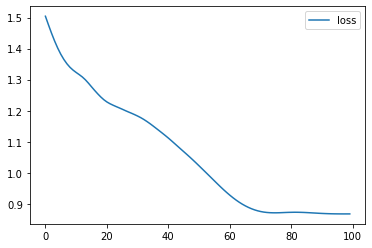

In [19]:
losses = pd.DataFrame(gpfa_hai.learner.losses.cpu().numpy(), columns=['loss'])

p = losses.plot()
plt.savefig(here('analysis/plots/loss_plot_hai_winter_4_var_200_obs_random_gaps_row_20_value_10.png'))
p

Lambda parameter, the latent variable is very similar to the 

In [21]:
gpfa_hai.data.corr()

,TA,SW_IN,LW_IN,VPD
TA,1.000000,-0.029446,0.411689,0.664939
SW_IN,-0.029446,1.000000,-0.318511,0.141072
LW_IN,0.411689,-0.318511,1.000000,-0.034296
VPD,0.664939,0.141072,-0.034296,1.000000


In [22]:
gpfa_hai.learner.model.covar_module.Lambda.detach()

tensor([[ 0.9332],
        [-0.0013],
        [ 0.3642],
        [ 0.5954]])

this is the value of the length scale of the RBF latent kernel

In [23]:
gpfa_hai.learner.model.covar_module.latent_kernel.lengthscale.detach()

tensor([[7.6128]])

In [38]:
gpfa_hai.learner.model.covar_module.psi.detach()

tensor([0.0018, 0.9886, 0.8362, 0.5784])

## Summer

The low correlation between `SW_IN` and `TA` is likely due to cloud cover, which is hard to predict with a dialy cycle. Hence we are looking at summer days and there is a much better correlation

In [24]:
hai_raw2 = pd.read_csv(here("data") / hai_path, na_values=["-9999", "-9999.99"], parse_dates=[0, 1], nrows= 7 * 30 * 24 * 2)

In [25]:
meteo_vars = {
    "TA_F": "TA",
    "SW_IN_F": "SW_IN",
    "LW_IN_F": "LW_IN",
    "VPD_F": "VPD",
    #"PA": "PA"
}

units = {
    'TA': '°C',
    'SW_IN': 'W m-2',
    'LW_IN': 'W m-2',
    'VPD': 'hPa'
}

hai2 = (hai_raw2
       .rename(columns=meteo_vars)
       .set_index("TIMESTAMP_END")
       .loc[:, meteo_vars.values()])
hai2

,TA,SW_IN,LW_IN,VPD
TIMESTAMP_END,,,,
2000-01-01 00:30:00,-0.60,0.0,302.475,0.222
2000-01-01 01:00:00,-0.65,0.0,302.475,0.122
2000-01-01 01:30:00,-0.58,0.0,301.677,0.090
2000-01-01 02:00:00,-0.51,0.0,301.677,0.110
2000-01-01 02:30:00,-0.49,0.0,301.677,0.102
...,...,...,...,...
2000-07-28 22:00:00,12.69,0.0,344.126,1.453
2000-07-28 22:30:00,12.49,0.0,355.901,1.077
2000-07-28 23:00:00,12.41,0.0,355.901,0.927


<AxesSubplot: xlabel='TIMESTAMP_END'>

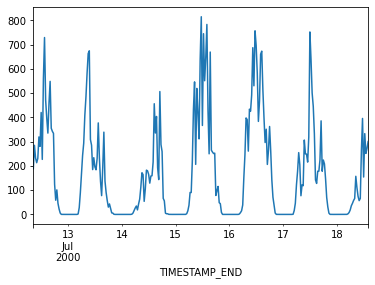

In [26]:
hai2[-800:-500].SW_IN.plot()

In [27]:
hai2[-800:-500].corr()

,TA,SW_IN,LW_IN,VPD
TA,1.000000,0.464253,0.555916,0.795267
SW_IN,0.464253,1.000000,0.106405,0.566460
LW_IN,0.555916,0.106405,1.000000,0.106487
VPD,0.795267,0.566460,0.106487,1.000000


In [28]:
gpdata2 = GPFADataTest(hai2[-800:-500].copy()).add_random_missing()

In [29]:
gp_imp2 = GPFAImputation(gpdata2.data, gpdata2.tidy_df(complete=True, is_missing=True))

In [30]:
%time data_imp2 = gp_imp2.impute()

CPU times: user 34min 45s, sys: 1.95 s, total: 34min 47s
Wall time: 8min 3s


In [31]:
gp_imp2.plot_pred(units=units)

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [32]:
data_imp2

,time,variable,mean,std
0,0.0,TA,9.370000,NaN
1,1.0,TA,9.770000,NaN
2,7.0,TA,11.180000,NaN
3,8.0,TA,11.100000,NaN
4,11.0,TA,12.290000,NaN
...,...,...,...,...
531,293.0,VPD,2.308679,1.134526
532,295.0,VPD,2.653569,1.135887
533,296.0,VPD,2.188000,0.000000
534,298.0,VPD,2.675000,0.000000


In [33]:
gp_imp2.rmse()

,variable,rmse
0,LW_IN,13.089628
1,SW_IN,182.345338
2,TA,0.363324
3,VPD,1.137403


In [34]:
gpdata2.data.corr()

,TA,SW_IN,LW_IN,VPD
TA,1.000000,0.459343,0.575352,0.793214
SW_IN,0.459343,1.000000,0.048263,0.585113
LW_IN,0.575352,0.048263,1.000000,0.115841
VPD,0.793214,0.585113,0.115841,1.000000


In [35]:
gp_imp2.learner.model.covar_module.Lambda.detach()

tensor([[0.8703],
        [0.3686],
        [0.5066],
        [0.6963]])

In [36]:
gp_imp2.learner.model.covar_module.psi.detach()

tensor([0.0069, 0.8080, 0.6462, 0.3624])

this is the value of the length scale of the RBF latent kernel

In [ ]:
gp_imp2.learner.model.covar_module.latent_kernel.lengthscale.detach()

### Only TA and SW_IN

In [ ]:
gpdata3 = GPFADataTest(hai2[-800:-500].loc[:, ["TA", "SW_IN"]].copy()).add_random_missing()

In [ ]:
gp_imp3 = GPFAImputation(gpdata3.data, gpdata3.tidy_df(complete=True, is_missing=True))

In [ ]:
%time data_imp3 = gp_imp3.impute()

In [ ]:
gp_imp3.plot_pred(units=units, bind_interaction=False)

In [ ]:
data_imp3

In [ ]:
gpdata3.data.corr()

In [ ]:
gp_imp3.learner.model.covar_module.Lambda.detach()

this is the value of the length scale of the RBF latent kernel

In [ ]:
gp_imp3.learner.model.covar_module.latent_kernel.lengthscale.detach()

In [ ]:
gp_imp3.learner.model.covar_module.latent_kernel.lengthscale.detach()

In [ ]:
#| hide
#! quarto preview "GPFA Hainich.ipynb"